In [5]:
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import CCE 
from scipy.optimize import differential_evolution
from pathlib import Path
from bgp_qnm_fits import *

In [6]:
with open("R_dict.pkl", "rb") as f:
    R_dict = pickle.load(f)

In [7]:
SIMNUMS = [
    "0001",
    "0002",
    "0003",
    "0004",
    "0005",
    "0006",
    "0007",
    "0008",
    "0009",
    "0010",
    "0011",
    "0012",
    "0013",
]
RINGDOWN_START_TIMES = [
    17.0,
    21.0,
    23.0,
    26.0,
    17.0,
    17.0,
    17.0,
    11.0,
    29.0,
    16.0,
    12.0,
    17.0,
    6.0,
]
TRAINING_SPH_MODES = [
    (2, 2),
    (2, 1),
    (3, 3),
    (3, 2),
    (4, 4),
    (2, -2),
    (2, -1),
    (3, -3),
    (3, -2),
    (4, -4),
]

SIM_TRAINING_MODE_RULES = {
    "0001": "PE",
    "0002": "PE",
    "0003": "PE",
    "0004": "PE",
    "0005": "P",
    "0006": "P",
    "0007": "P",
    "0008": "ALL",
    "0009": "E",
    "0010": "P",
    "0011": "P",
    "0012": "P",
    "0013": "ALL",
}

SMOOTHNESS = 16
EPSILON = 1 / 10

# These determine the parameter and training range but do not have to match `analysis times' used later.

TRAINING_START_TIME = -10
TRAINING_END_TIME = 100
TIME_STEP = 0.1

analysis_times = np.arange(
    TRAINING_START_TIME,
    TRAINING_START_TIME + TRAINING_END_TIME,
    TIME_STEP,
)  

# Define training bounds

SIGMA_MAX_LOWER, SIGMA_MAX_UPPER = 0.1, 5
T_S_LOWER, T_S_UPPER = -20, 30
LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER = 0.1, 5
PERIOD_LOWER, PERIOD_UPPER = 0.1, 5

SMOOTHNESS_LOWER, SMOOTHNESS_UPPER = 0, 30
LENGTH_SCALE_2_LOWER, LENGTH_SCALE_2_UPPER = 0.1, 5
PERIOD_2_LOWER, PERIOD_2_UPPER = 0.1, 5
A_LOWER, A_UPPER = 0, 0.9

BOUNDS_WN = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
]

BOUNDS_GP = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
    (T_S_LOWER, T_S_UPPER),
    (LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER),
    (PERIOD_LOWER, PERIOD_UPPER),
]

BOUNDS_GPC = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
    (T_S_LOWER, T_S_UPPER),
    (SMOOTHNESS_LOWER, SMOOTHNESS_UPPER),
    (LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER),
    (PERIOD_LOWER, PERIOD_UPPER),
    (LENGTH_SCALE_2_LOWER, LENGTH_SCALE_2_UPPER),
    (PERIOD_2_LOWER, PERIOD_2_UPPER),
    (A_LOWER, A_UPPER),
]

# Set initial params

# INITIAL_PARAMS_WN = [1.]
# INITIAL_PARAMS_GP = [1.0, 0.0, 1.0, 1.0]
# INITIAL_PARAMS_GPC = [0.5715534011443748, 0.0032311845355438894, SMOOTHNESS, 1.7176362780942858, 0.31558556618927797, 1.7176362780942858, 0.31558556618927797, 0.5]

INITIAL_PARAMS_WN = [0.29127733345656215]
INITIAL_PARAMS_GP = [
    0.2283378440307793,
    18.37394010821784,
    0.8610899535603144,
    0.2605530172829033,
]
# INITIAL_PARAMS_GPC = [0.5678699426741673, 3.3680141572797027, 7.841502124072786, 1.241209026430354, 0.9894982312667636, 0.1064862157208278, 0.139811581920352, 0.5917377132835934]
INITIAL_PARAMS_GPC = [
    0.29443340366568055,
    17.00880319694479,
    8.52342433839235,
    0.992215662729599,
    0.29792754163345136,
    1.4599452640915012,
    3.702622948813973,
    0.8844594560538273,
]

# Define rules for updating params

HYPERPARAM_RULE_DICT_WN = {
    "sigma_max": "multiply",
}

HYPERPARAM_RULE_DICT_GP = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

HYPERPARAM_RULE_DICT_GPC = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "sharpness": "replace",
    "length_scale": "multiply",
    "period": "multiply",
    "length_scale_2": "multiply",
    "period_2": "multiply",
    "a": "replace",
}

In [ ]:
with open("param_dict_mini.pkl", "rb") as f:
    param_dict = pickle.load(f)
with open("R_dict_mini.pkl", "rb") as f:
    R_dict = pickle.load(f)

TRAINING_START_TIME = -10
TRAINING_END_TIME = 100
TIME_STEP = 0.1

analysis_times = np.arange(
    TRAINING_START_TIME,
    TRAINING_START_TIME + TRAINING_END_TIME,
    TIME_STEP,
)  

#data_mask = np.ones_like(analysis_times, dtype=bool)
#data_mask[analysis_times > 20] = False

#R_dict_masked = {k:{K:V[data_mask] for K, V in v.items()} for k, v in R_dict.items()}
#analysis_times_masked = analysis_times[data_mask]


In [ ]:
dt_range = np.linspace(0.4, 5, 20)[::-1]
sigma_maxes = np.zeros((len(dt_range), 4))

TRAINING_START_TIME = -10
TRAINING_END_TIME = 100
TIME_STEP = 0.1

main_times = np.arange(
    TRAINING_START_TIME,
    TRAINING_START_TIME + TRAINING_END_TIME,
    TIME_STEP,
)  

for i, dt in enumerate(dt_range):

    data_mask = np.ones_like(analysis_times, dtype=bool)
    data_mask[analysis_times > 20] = False

    new_times = np.arange(TRAINING_START_TIME, TRAINING_START_TIME+TRAINING_END_TIME, dt)
    R_dict_interp = {k:sim_interpolator_data(v, main_times, new_times) for k, v in R_dict.items()}

    hyperparam_list, le, tuned_params = train_hyper_params(
        TRAINING_START_TIME,
        TRAINING_END_TIME,
        dt,
        INITIAL_PARAMS_GP,
        BOUNDS_GP,
        param_dict,
        R_dict_interp,
        HYPERPARAM_RULE_DICT_GP,
        kernel_main,
        TRAINING_SPH_MODES,
        SIM_TRAINING_MODE_RULES,
    )

    sigma_maxes[i] = hyperparam_list
    print(f"dt: {dt} hyperparam_list: {hyperparam_list})")

Optimal parameters: {'sigma_max': 0.2945769594996247} Log evidence: -36031.49485208619
Tuning parameters...
dt: 5.0 hyperparam_list: [0.29457696])
Optimal parameters: {'sigma_max': 0.28780703710092737} Log evidence: -39747.21954929818
Tuning parameters...
dt: 4.757894736842105 hyperparam_list: [0.28780704])
Optimal parameters: {'sigma_max': 0.2888310589763605} Log evidence: -41535.99481675631
Tuning parameters...
dt: 4.515789473684211 hyperparam_list: [0.28883106])
Optimal parameters: {'sigma_max': 0.2905377621020826} Log evidence: -43310.529577516034
Tuning parameters...
dt: 4.273684210526316 hyperparam_list: [0.29053776])
Optimal parameters: {'sigma_max': 0.2929840365822842} Log evidence: -45069.36866400386
Tuning parameters...
dt: 4.031578947368421 hyperparam_list: [0.29298404])
Optimal parameters: {'sigma_max': 0.2906515423104641} Log evidence: -48721.77195050928
Tuning parameters...
dt: 3.789473684210526 hyperparam_list: [0.29065154])
Optimal parameters: {'sigma_max': 0.2897981907

KeyboardInterrupt: 

In [26]:
hyperparam_list

array([ 0.14900166, 20.51893627,  1.07284952,  0.26944204])

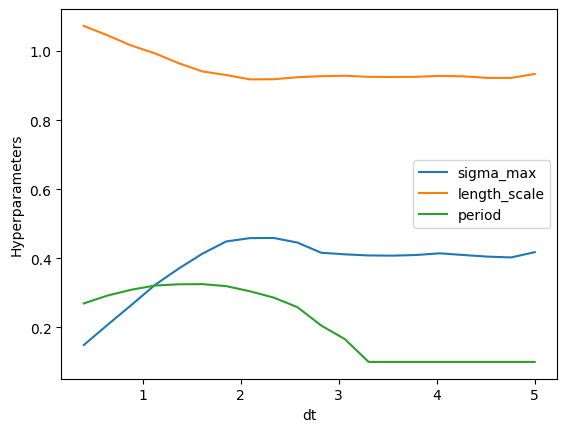

In [32]:
plt.plot(dt_range, sigma_maxes[:, 0], label="sigma_max")
#plt.plot(dt_range, sigma_maxes[:, 1], label="t_s")
plt.plot(dt_range, sigma_maxes[:, 2], label="length_scale")
plt.plot(dt_range, sigma_maxes[:, 3], label="period")
plt.xlabel("dt")
plt.ylabel("Hyperparameters")
#plt.yscale("log")
plt.legend()

In [ ]:
dt_range = np.linspace(0.2, 1, 10)[::-1]
hyperparameters_list = np.zeros((len(dt_range), 4))

TRAINING_START_TIME = -10
TRAINING_END_TIME = 100
TIME_STEP = 0.1

main_times = np.arange(
    TRAINING_START_TIME,
    TRAINING_START_TIME + TRAINING_END_TIME,
    TIME_STEP,
)  

for i, dt in enumerate(dt_range):

    new_times = np.arange(TRAINING_START_TIME, TRAINING_START_TIME+TRAINING_END_TIME, dt)
    R_dict_interp = {k:sim_interpolator_data(v, main_times, new_times) for k, v in R_dict.items()}

    hyperparam_list, le, tuned_params = train_hyper_params(
        TRAINING_START_TIME,
        TRAINING_END_TIME,
        dt,
        INITIAL_PARAMS_GP,
        BOUNDS_GP,
        param_dict,
        R_dict_interp,
        HYPERPARAM_RULE_DICT_GP,
        kernel_main,
        TRAINING_SPH_MODES,
        SIM_TRAINING_MODE_RULES,
    )

    hyperparameters_list[i] = hyperparam_list
    print(f"dt: {dt} hyperparam_list: {hyperparam_list})")

Optimal parameters: {'sigma_max': 0.292813366269712} Log evidence: -180288.8537567043
Tuning parameters...
dt: 1.0 hyperparam_list: [0.29281337])
Optimal parameters: {'sigma_max': 0.29247202564456753} Log evidence: -198347.53711193203
Tuning parameters...
dt: 0.9111111111111112 hyperparam_list: [0.29247203])
Optimal parameters: {'sigma_max': 0.29228713280594776} Log evidence: -220000.59206722723
Tuning parameters...
dt: 0.8222222222222222 hyperparam_list: [0.29228713])
Optimal parameters: {'sigma_max': 0.29204534986313707} Log evidence: -247076.82388579356
Tuning parameters...
dt: 0.7333333333333334 hyperparam_list: [0.29204535])
Optimal parameters: {'sigma_max': 0.2919031246026602} Log evidence: -281358.448921937
Tuning parameters...
dt: 0.6444444444444445 hyperparam_list: [0.29190312])
Optimal parameters: {'sigma_max': 0.29264269595713976} Log evidence: -324543.7736566702
Tuning parameters...
dt: 0.5555555555555556 hyperparam_list: [0.2926427])
Optimal parameters: {'sigma_max': 0.292

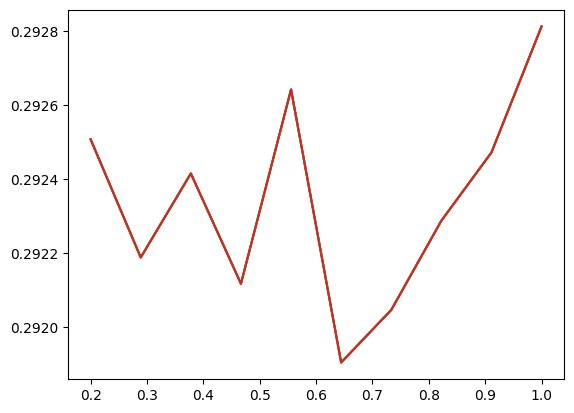

In [39]:
sigmas = [0.2939707273653811, 0.27210463, 0.25044353, 0.22881571]
dts = [1, 0.9111111111111112, 0.8222222222222222, 0.7333333333333333]

plt.plot(dt_range, hyperparameters_list, label="sigma_max")

In [ ]:
plt.plot(sigma_max_range, likelihoods)
plt.xlabel("Sigma Max")
plt.ylabel("Likelihood")
#plt.yscale("log")
plt.show()


/data/vault/rvnd2/python_envs/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/data/vault/rvnd2/python_envs/venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


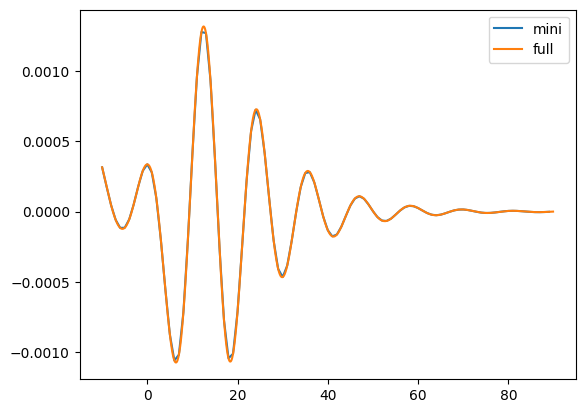

In [ ]:
with open("R_dict_mini.pkl", "rb") as f:
    R_dict_mini = pickle.load(f)

with open("R_dict.pkl", "rb") as f:
    R_dict = pickle.load(f)

analysis_times_mini = np.arange(
    -10,
    90,
    1,
)  


analysis_times = np.arange(
    -10,
    90,
    0.1,
)  

plt.plot(analysis_times_mini, R_dict_mini["0001"][(2, 2)], label="mini")
plt.plot(analysis_times, R_dict["0001"][(2, 2)], label="full")
plt.legend() 

In [ ]:
with open("param_dict_mini.pkl", "rb") as f:
    param_dict_mini = pickle.load(f)

with open("param_dict.pkl", "rb") as f:
    param_dict = pickle.load(f)

In [ ]:
sim_id = "0001"

In [ ]:
sim_main = CCE.SXS_CCE(sim_id, lev="Lev5", radius="R2")
sim_lower = CCE.SXS_CCE(sim_id, lev="Lev4", radius="R2") 

In [ ]:
R_mini = get_residuals(sim_main, sim_lower, -10, 100, dt=1)

KeyboardInterrupt: 

In [ ]:
sim_main = CCE.SXS_CCE(sim_id, lev="Lev5", radius="R2")
sim_lower = CCE.SXS_CCE(sim_id, lev="Lev4", radius="R2") 

In [ ]:
R = get_residuals(sim_main, sim_lower, -10, 100, dt=0.1)

Time shift: -0.11220000000000001
Masked times: [-10.   -9.9  -9.8  -9.7  -9.6  -9.5  -9.4  -9.3  -9.2  -9.1  -9.   -8.9
  -8.8  -8.7  -8.6  -8.5  -8.4  -8.3  -8.2  -8.1  -8.   -7.9  -7.8  -7.7
  -7.6  -7.5  -7.4  -7.3  -7.2  -7.1  -7.   -6.9  -6.8  -6.7  -6.6  -6.5
  -6.4  -6.3  -6.2  -6.1  -6.   -5.9  -5.8  -5.7  -5.6  -5.5  -5.4  -5.3
  -5.2  -5.1  -5.   -4.9  -4.8  -4.7  -4.6  -4.5  -4.4  -4.3  -4.2  -4.1
  -4.   -3.9  -3.8  -3.7  -3.6  -3.5  -3.4  -3.3  -3.2  -3.1  -3.   -2.9
  -2.8  -2.7  -2.6  -2.5  -2.4  -2.3  -2.2  -2.1  -2.   -1.9  -1.8  -1.7
  -1.6  -1.5  -1.4  -1.3  -1.2  -1.1  -1.   -0.9  -0.8  -0.7  -0.6  -0.5
  -0.4  -0.3  -0.2  -0.1   0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7
   0.8   0.9   1.    1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9
   2.    2.1   2.2   2.3   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1
   3.2   3.3   3.4   3.5   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3
   4.4   4.5   4.6   4.7   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5
   5

In [ ]:
R[(2,2)].shape

(1000,)

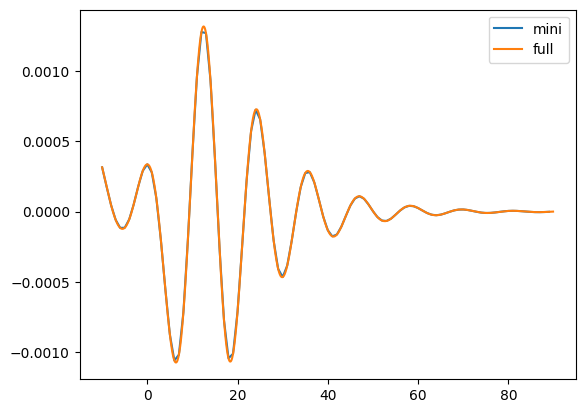

In [ ]:
analysis_times_mini = np.arange(
    -10,
    90,
    1,
)  


analysis_times = np.arange(
    -10,
    90,
    0.1,
)  

plt.plot(analysis_times_mini, R_mini[(2, 2)], label="mini")
plt.plot(analysis_times, R[(2, 2)], label="full")
plt.legend() 